# In-place and out-of-place evaluation
The inplace evaluation is easier and slightly faster.

In [78]:
using Plots, LinearAlgebra
# Creating an SPD test problem
m=5555;eps=0.1
A=rand(m,m); A=A*A'+ eps*I
x0=rand(m);xStar=sin.(2*pi/m*(1:m));b=A*xStar
# Making Storage for errors ||x-xStar|| and ||b-A*x||
MaxIter=5
SDErrs=zeros(MaxIter,2); MRerrs=zeros(MaxIter,2); NRErrs=zeros(MaxIter,2)

#Steepest Descent Step from Alg 5.2 p138
#Assumption A is SPD
function SteepDes(A,x,p,r)
    alpha = dot(r,r)/dot(p,r)
    x+=alpha*r
    r-=alpha*p
    p=A*r
    return (x,p,r)
end

function SteepDes!(A,x,p,r)
    alpha = dot(r,r)/dot(p,r)
    x.+=alpha*r
    r.-=alpha*p
    p.=A*r
    return nothing
end

# SD
xPass=copy(x0);r=b-A*x0;p=A*r
for i in 1:MaxIter
    @time (xPass,p,r)= SteepDes(A,xPass,p,r)
end

xNoPass=copy(x0);r=b-A*x0;p=A*r
for i in 1:MaxIter
    @time SteepDes!(A,xNoPass,p,r)
end

(norm(xPass-xStar),norm(xNoPass-xStar))

  0.027632 seconds (2.44 k allocations: 356.314 KiB, 39.01% compilation time)
  0.017009 seconds (14 allocations: 217.703 KiB)
  0.017186 seconds (14 allocations: 217.703 KiB)
  0.017105 seconds (14 allocations: 217.703 KiB)
  0.017827 seconds (14 allocations: 217.703 KiB)
  0.089458 seconds (35.51 k allocations: 1.708 MiB, 76.87% compilation time)
  0.018121 seconds (6 allocations: 130.547 KiB)
  0.019491 seconds (6 allocations: 130.547 KiB)
  0.021565 seconds (6 allocations: 130.547 KiB)
  0.027706 seconds (6 allocations: 130.547 KiB)


(40.571085241238585, 40.571085241238585)

# 1D Projection Schemes

There are three 1D algorithms in Chapter 5.  Here are fixed iteration count version in Julia

In [67]:
using LinearAlgebra, SparseArrays
#Steepest Descent Step from Alg 5.2 p138
#Assumption A is SPD
function SteepDes(A,x,p,r)
    alpha = dot(r,r)/dot(p,r)
    x.+=alpha*r
    r.-=alpha*p
    p.=A*r
    return nothing
end

#Minimum Residual Step from Alg 5.3 p140
#Assumption A+A' is SPD
function MinRes(A,x,p,r)
    alpha = dot(p,r)/dot(p,p)
    x.=x+alpha*r
    r.=r-alpha*p
    p.=A*r
    return nothing
end

#Residual Norm Step from Alg 5.4 p142
#Assumption A'A is non-singular
function ResNorm(A,x,r)
    v=A'*r
    Av=A*v
    alpha = dot(v,v)/dot(Av,Av)
    x.=x+alpha*v
    r.=r-alpha*Av
    return nothing
end
;

# Assumptions
The assumptiions are real:

- Just because an algorithm runs does not mean it is converging! 
- Algorithms will (almost certainly) fail to converge on matrices that fail to satisfy the assumptions.
- SD has the most stringent assuptions followed by MR followed by RN.
- The assumptions for RN are *almost* non existent.

# Foot Race
As a test I am going to compare all three on a randomly generated SPD matrix. 

In [68]:
using Plots, LinearAlgebra, BenchmarkTools
# Creating an SPD test problem
m=55;eps=1.2
A=rand(m,m); A=A*A'+ eps*I
x0=rand(m);xStar=sin.(2*pi/m*(1:m));b=A*xStar
# Making Storage for errors ||x-xStar|| and ||b-A*x||
MaxIter=50
SDErrs=zeros(MaxIter,2); MRErrs=zeros(MaxIter,2); NRErrs=zeros(MaxIter,2)

# SD Test
x=copy(x0);r=b-A*x0;p=A*r
for i in 1:MaxIter
    SteepDes(A,x,p,r)
    SDErrs[i,1]=norm(r)
    SDErrs[i,2]=norm(x-xStar)
end

# MR Test
x=copy(x0);r=b-A*x0;p=A*r
for i in 1:MaxIter
    MinRes(A,x,p,r)
    MRErrs[i,1]=norm(r)
    MRErrs[i,2]=norm(x-xStar)
end

# ResNorm Test
x=copy(x0);r=b-A*x0
for i in 1:MaxIter
    ResNorm(A,x,r)
    NRErrs[i,1]=norm(r)
    NRErrs[i,2]=norm(x-xStar)
end

Lets look at the results

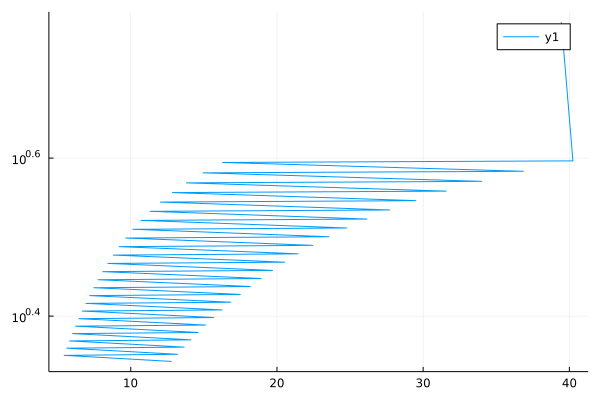

In [70]:
using Plots
plot(SDErrs[:,1],SDErrs[:,2],yaxis=:log)